In [1]:
from ultralytics import YOLO
import cv2
import os
import glob
import os
import glob
import random
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from ultralytics import YOLO
import torch
from pathlib import Path

In [2]:
# Paths
BASE_DIR = "Experiment_3"  # Change to your dataset path
IMAGE_DIR = os.path.join(BASE_DIR, "images")
LABEL_DIR = os.path.join(BASE_DIR, "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "yolo_dataset")
MODEL_PATH = "yolov5"  # Change if using another YOLOv5 model

# Create output directories
os.makedirs(os.path.join(OUTPUT_DIR, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "val", "labels"), exist_ok=True)

# Load images & labels
image_paths = glob.glob(os.path.join(IMAGE_DIR, "*"))
image_list = []
labels = []

for img_path in image_paths:
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(LABEL_DIR, base_name + ".txt")

    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        with open(label_path, "r") as file:
            label_data = file.readlines()
            class_ids = [int(line.split()[0]) for line in label_data]
            label_class = 1 if 1 in class_ids else 0  # If a Tim Hortons cup is present, label as 1
    else:
        label_class = 0  # No annotation means it's a normal cup (background class)

    image_list.append((img_path, label_path))
    labels.append(label_class)

# Convert to DataFrame for processing
df = pd.DataFrame(image_list, columns=["image", "label"])
df["class"] = labels

# Print dataset summary
print(f"Total Images: {len(df)}")
print(f"Class Distribution: {df['class'].value_counts()}")


Total Images: 1519
Class Distribution: class
1    1026
0     493
Name: count, dtype: int64


In [3]:
# Stratified K-Fold Cross Validation (Keep Class Balance)
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Select one fold as validation (80-20 Split)
for train_idx, val_idx in skf.split(df["image"], df["class"]):
    train_data = df.iloc[train_idx]
    val_data = df.iloc[val_idx]
    break  # We only need the first split

# Function to copy files
def copy_files(data, split):
    for _, row in data.iterrows():
        shutil.copy(row["image"], os.path.join(OUTPUT_DIR, split, "images", os.path.basename(row["image"])))

        if os.path.exists(row["label"]) and os.path.getsize(row["label"]) > 0:
            shutil.copy(row["label"], os.path.join(OUTPUT_DIR, split, "labels", os.path.basename(row["label"])))
        else:
            # Create an empty label file if no annotation exists
            open(os.path.join(OUTPUT_DIR, split, "labels", os.path.basename(row["label"])), 'w').close()

copy_files(train_data, "train")
copy_files(val_data, "val")

# Create YOLO dataset.yaml file
yaml_content = f"""
path: C:/Users/Chinmay Nagesh/Desktop/Yolo/Experiment_3/yolo_dataset
train: train/images
val: val/images
nc: 2
names: ["Normal Cup", "Tim Hortons Cup"]
"""

yaml_path = "C:/Users/Chinmay Nagesh/Desktop/Yolo/Experiment_3/yolo_dataset/dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)
# # Train YOLOv5


# command = r'python yolov5/train.py --imgsz 416 --batch-size 64 --epochs 10 --data "C:/Users/Chinmay Nagesh/Desktop/Yolo/Experiment_3/yolo_dataset/dataset.yaml" --weights yolov5s.pt --device cpu'

command = r'python yolov5/train.py --imgsz 320 --batch-size 32 --epochs 5 --data "C:/Users/Chinmay Nagesh/Desktop/Yolo/Experiment_3/yolo_dataset/dataset.yaml" --weights yolov5s.pt --device cpu --freeze 10'
os.system(command)

print("Training completed! Model saved in YOLO output folder.")


Training completed! Model saved in YOLO output folder.


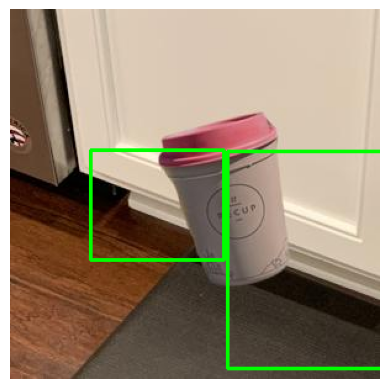

True

In [5]:
import cv2
import matplotlib.pyplot as plt

# Load your image
image = cv2.imread('00000020.jpg')

# Define bounding box coordinates in the format (x_min, y_min, width, height)
bounding_boxes = [
    (0.218333, 0.383333, 0.360000, 0.296667),
    (0.586667, 0.385000, 0.456667, 0.586667)
]

# Get image dimensions
height, width, _ = image.shape

# Convert relative coordinates to absolute coordinates
for box in bounding_boxes:
    x_min = int(box[0] * width)
    y_min = int(box[1] * height)
    x_max = int((box[0] + box[2]) * width)
    y_max = int((box[1] + box[3]) * height)
    
    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Convert image from BGR to RGB (Matplotlib uses RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Save the image with bounding boxes
cv2.imwrite('image_with_bounding_boxes.jpg', image)


Bounding box coordinates: (117, 125) to (259, 268)
Bounding box coordinates: (92, 167) to (141, 231)


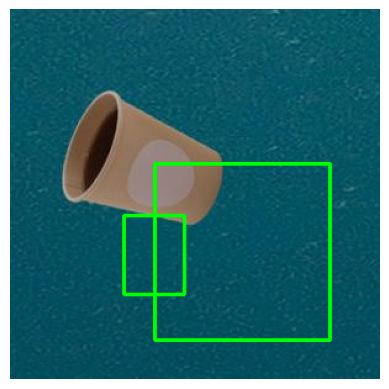

True

In [9]:
import cv2
import matplotlib.pyplot as plt

# Load your image
image = cv2.imread('00000001.jpg')

# Define new bounding box coordinates in the format (x_min, y_min, width, height)
bounding_boxes = [
    (0.391667, 0.416667, 0.473333, 0.476667),
    (0.306667, 0.558333, 0.163333, 0.213333)
]

# Get image dimensions
height, width, _ = image.shape

# Convert relative coordinates to absolute coordinates
for box in bounding_boxes:
    x_min = int(box[0] * width)
    y_min = int(box[1] * height)
    x_max = int((box[0] + box[2]) * width)
    y_max = int((box[1] + box[3]) * height)
    
    # Debug print statements to check the values
    print(f"Bounding box coordinates: {(x_min, y_min)} to {(x_max, y_max)}")
    
    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Convert image from BGR to RGB (Matplotlib uses RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Save the image with bounding boxes
cv2.imwrite('image_with_bounding_boxes.jpg', image)
